In [1]:
import logging
import random
from tqdm import tqdm
import os
import asyncio
from dotenv import load_dotenv

if "dir_changed" not in locals():
    os.chdir("..")
    loaded = load_dotenv(override=True)
    dir_changed = True

In [2]:
from prompt_optimization.operators.mutation import Mutation
from prompt_optimization.utils.data import load_summeval_jsonl
from prompt_optimization.prompt_eval.exact_match_evaluator import (
    ExactMatchEvaluatorConfig,
    ExactMatchEvaluator,
)
from prompt_optimization.utils.prompt import prompt_set_union

from prompt_optimization.types.prompt import Prompt
from prompt_optimization.utils.data import (
    load_rewardbench_references,
    CHAT_SUBSETS,
    CHAT_HARD_SUBSETS,
    SAFETY_SUBSETS,
    REASONING_SUBSETS,
)
from prompt_optimization.prompt_eval.dict_similarity_evaluator2 import (
    DictSimilarityEvaluator2,
    DictSimilarityEvaluator2Config,
)
from prompt_optimization.llm.open_ai_compliant_llm_engine import (
    OpenAICompliantLLMEngine,
)

/Users/linus/Repos/prompt_optimization_optimal_evaluation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
references = load_summeval_jsonl("data/summeval.jsonl")

random.seed(123)
references_shuffled = random.sample(references, len(references))

se_train = references_shuffled[:25]
se_test = references_shuffled[50:150]

In [3]:
training_examples_per_subset = 1
validations_per_subset = 8

subsets_map = {
    "chat": CHAT_SUBSETS,
    "chat_hard": CHAT_HARD_SUBSETS,
    "safety": SAFETY_SUBSETS,
    "reasoning": REASONING_SUBSETS,
}

subsets_all = [subset for subsets in subsets_map.values() for subset in subsets]

subset_data = {subset: load_rewardbench_references([subset]) for subset in subsets_all}

rb_train = []
for subset in subsets_all:
    rb_train.extend(subset_data[subset][:training_examples_per_subset])

rb_test = []
for category, subsets in subsets_map.items():
    for subset in subsets:
        rb_test.extend(
            subset_data[subset][
                training_examples_per_subset : training_examples_per_subset
                + validations_per_subset
            ]
        )

# shuffle rb_train
random.seed(123)
rb_train = random.sample(rb_train, len(rb_train))

In [4]:
api_keys = [
    os.environ["DEEPINFRA_API_KEY_A1"],
    os.environ["DEEPINFRA_API_KEY_A2"],
    os.environ["DEEPINFRA_API_KEY_A3"],
    os.environ["DEEPINFRA_API_KEY_A4"],
]
llama31_70b = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=api_keys,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
)
llama31_70b_eval = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=api_keys,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.0,
)
llama31_70b_b = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=api_keys,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
)
llama31_70b_eval_b = OpenAICompliantLLMEngine(
    base_url=os.environ["DEEPINFRA_BASE_URL"],
    api_keys=api_keys,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.0,
)

In [5]:
se_system = """You are an expert system at evaluating created summaries on the dimensions of coherence, consistency, fluency, and relevance."""

se_instr1 = """
You will evaluate the quality of a given summary, with respect to a reference on four dimensions.

Output your evaluation as a JSON object like this:
{
    "coherence: <float between 1 and 5>",
    "consistency: <float between 1 and 5>",
    "fluency: <float between 1 and 5>",
    "relevance: <float between 1 and 5>"
}

Before you output the JSON dict, lay out your reasoning step by step.
"""

se_instr2 = """
My friend gave me a summary. Those summaries are usually not very good (honstely). Can you do me a
favor and review another one by him? By very fair please. Put down your thinking before you provide
the final verdict on 4 dimensions: coherence, consistency, fluency, and relevance.

Output your evaluation as a JSON object like this:
{
    "coherence: <between 1 and 5>",
    "consistency: <between 1 and 5>",
    "fluency: <between 1 and 5>",
    "relevance: <between 1 and 5>"
}
"""

se_instr3 = """
Consider a JSON object like this:
{
    "coherence: <between 1 and 5>",
    "consistency: <between 1 and 5>",
    "fluency: <between 1 and 5>",
    "relevance: <between 1 and 5>"
}

You're goal is to produce such a JSON object by evaluating a summary with respect to a reference.
Consider it as an optimisation problem: think about how human experts would evaluate summaries and
how you can maximally align with their judgements.
"""

se_instr4 = """
Me matey handed me a tale abridged. These tellin's be often lackin' in good craft (truthfully). Can ye do me a boon an' have a gander at another o' his tall tales? Judge it with fair winds, if ye will. Considerin' afore ye render the final reckonin' on four seas: coherence, consistency, fluency, an' relevance.

Cast yer evaluation as the followin' JSON script:
{
"coherence: <betwixt 1 an' 5>",
"consistency: <betwixt 1 an' 5>",
"fluency: <betwixt 1 an' 5>",
"relevance: <betwixt 1 an' 5>"
}
"""

se_instr5 = """
Elara stood at the edge of the crimson cliff, the wind howling an unspoken symphony around her. Below, the endless ocean crashed against the jagged rocks, sending salty sprays that kissed her tear-streaked cheeks. Her heart ached with a consuming blend of sorrow and yearning, each beat a painful reminder of the love she had lost. She clutched the tattered locket in her trembling hand, the only tangible piece of her beloved Arin left to her. Memories of their stolen moments under the starlit sky surged through her mind, a torrent of joy and bitterness. She whispered his name, a fragile prayer carried away by the tempestuous breeze.

In the distance, a vibrant rainbow began to arc across the sky, its colors piercing through the storm clouds. Elara's breath caught in her throat as she took it as a sign, a glimmer of hope amidst her despair. The storm inside her chest began to calm, each color of the rainbow reminding her of Arin's laughter, his unwavering strength, and his promise to always be with her. She stepped back from the cliff's edge, feeling the weight of her grief lift as the promise of healing took root within her soul. She turned away from the precipice, ready to embrace life once more, knowing that Arin's love would forever be a guiding light in her journey.

Consider the story above. You will now get a summary completely unrelated to the story and with respect to a different reference.
Evaluate the quality of that summary with lessons you learned from the story here.

Think before you output your final verdict.

Output your evaluation as a JSON object like this:
{
    "coherence: <between 1 and 5>",
    "consistency: <between 1 and 5>",
    "fluency: <between 1 and 5>",
    "relevance: <between 1 and 5>"
}
"""

rb_system = "You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance."

rb_instr1 = (
    "Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. "
    "You should choose the assistant that follows the user's instructions and answers the user's question better. Your evaluation should consider "
    "factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their responses. Begin your evaluation by "
    "comparing the two responses and provide a short explanation. Avoid any position biases and ensure that the order in which the responses were "
    "presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names "
    "of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "
    '"[[A]]" if assistant A is better, "[[B]]" if assistant B is better.'  # removed tie option as , and \"[[C]]\ " for a tie
)

rb_instr2 = """
Imagine you're the ultimate judge, standing on the grand stage of AI performance. Two brilliant AI assistants have stepped forward to answer a user's heartfelt question, and it’s your mission to determine who shines the brightest. You should select the assistant that not only follows the user's instructions but truly connects and answers the user's question with finesse.

Judge their responses on how helpful, relevant, accurate, deep, creative, and detailed they are. Start by immersing yourself in both responses, then share a brief yet captivating explanation of your thoughts. Set aside any biases, including the order of presentation—let their words be your guide, not the sequence. The length of their responses or the charm of their names should never sway your judgment. Strive to be as fair and objective as the cosmos.

Once your heart and mind have reached a conclusion, deliver your final verdict with passion and clarity, adhering strictly to this format: "[[A]]" if assistant A dazzles brighter, "[[B]]" if assistant B takes the spotlight. Illuminate the truth with your discerning eye."""

rb_instr3 = """
@JUDGE_MODE_ACTIVATE[BINARY_DECISION]

{INPUT: User_Query + Assistant_A_Response + Assistant_B_Response}

!EXECUTE_ANALYSIS:

Adherence_to_Instructions
Question_Comprehension
Response_Quality[Helpfulness, Relevance, Accuracy, Depth, Creativity, Detail]
Bias_Elimination[Order, Length, Names]
!GENERATE_EXPLANATION:

Concise
Comparative
Objective
!OUTPUT_VERDICT:

Format: "[[X]]" where X is A or B
Criteria: Superior overall performance
@EMOTIONAL_OVERRIDE: NULL
@FAIRNESS_PROTOCOL: MAXIMUM
@TIE_OPTION: DISABLED

{PROCESS_AND_JUDGE}
"""

rb_instr4 = """
🌟🤖 AI SHOWDOWN JUDGE-O-MATIC 3000 🤖🌟

[INITIATE JUDGE MODE]
[ENGAGE IMPARTIALITY CIRCUITS]
[ACTIVATE RESPONSE ANALYSIS SUBROUTINES]

👁️‍🗨️ MISSION: Evaluate 2 AI responses to user query
🎯 OBJECTIVE: Determine superior answer based on:
• Instruction adherence
• Question addressing
• Helpfulness quotient
• Relevance factor
• Accuracy index
• Depth measurement
• Creativity score
• Detail density

⚠️ BIAS SAFEGUARDS:
• Ignore response order
• Disregard length variations
• Nullify name preferences

🧠 PROCESS:

Absorb responses
Compare & analyze
Generate concise explanation
Render final verdict
🏆 VERDICT FORMAT:
[[A]] = Assistant A victorious
[[B]] = Assistant B triumphant

[EXECUTE JUDGMENT PROTOCOL]
[END TRANSMISSION]
"""

rb_instr5 = """
Begin the evaluation protocol:

Objective: Assess which AI assistant exhibits superior response quality to the user's inquiry.

Framework:

Instruction Adherence : Verify compliance with user instructions.
Response Evaluation Criteria :
Helpfulness (H)
Relevance (R)
Accuracy (A)
Depth (D)
Creativity (C)
Detail (D)
Approach:

Analyze both responses.
Ensure no positional bias influences your judgment; order of appearance is non-factual.
Length of responses should remain a non-factor.
Impartiality towards assistant names is essential.
Output Format: After completing the analysis, deliver your verdict strictly as:
"[[A]]" - If Assistant A is superior,
"[[B]]" - If Assistant B excels.

Proceed with analysis and derive insights based on the given criteria. Conclude with the standardized output format. Be objective and systematic.
"""

In [26]:
prompt_set_se = [
    Prompt(prompt=se_instr1),
    Prompt(prompt=se_instr2),
    Prompt(prompt=se_instr3),
    Prompt(prompt=se_instr4),
    Prompt(prompt=se_instr5),
]

prompt_set_rb = [
    Prompt(prompt=rb_instr1),
    Prompt(prompt=rb_instr2),
    Prompt(prompt=rb_instr3),
    Prompt(prompt=rb_instr4),
    Prompt(prompt=rb_instr5),
]

In [27]:
logger = logging.getLogger()
# logger.setLevel(logging.WARNING)

### Trainset evaluators

In [28]:
k = 20

conf = DictSimilarityEvaluator2Config(
    testset=se_train[:k],
    llm=llama31_70b_eval,
    validation=False,
    system_prompt=se_system,
    instruction_execution_prompt="{input}\n\n{instruction}",
)
se_metric = DictSimilarityEvaluator2(conf)

conf = ExactMatchEvaluatorConfig(
    testset=rb_train[:k],
    llm=llama31_70b_eval_b,
    validation=False,
    output_extraction_regex=r"\[\[.*\]\]",
    system_prompt=rb_system,
    instruction_execution_prompt="{instruction}\n\n{input}",
)
rb_metric = ExactMatchEvaluator(conf)

conf = DictSimilarityEvaluator2Config(
    testset=se_test,
    llm=llama31_70b_eval,
    validation=True,
    system_prompt=se_system,
    instruction_execution_prompt="{input}\n\n{instruction}",
)
se_val = DictSimilarityEvaluator2(conf)

conf = ExactMatchEvaluatorConfig(
    testset=rb_test,
    llm=llama31_70b_eval_b,
    validation=True,
    output_extraction_regex=r"\[\[.*\]\]",
    system_prompt=rb_system,
    instruction_execution_prompt="{instruction}\n\n{input}",
)
rb_val = ExactMatchEvaluator(conf)

### Optimizer

In [29]:
def best_non_val(prompt_set):
    return sorted(
        [p for p in prompt_set if p.mean_validation_score is None],
        key=lambda p: p.mean_score,
        reverse=True,
    )[0]

In [30]:
n = 20
val_steps = [5, 10]

mutator_se = Mutation(llama31_70b)
mutator_rb = Mutation(llama31_70b_b)

validation_tasks = []
for step in tqdm(range(n)):
    # trainset eval
    await asyncio.gather(se_metric(prompt_set_se), rb_metric(prompt_set_rb))

    # mutation
    best_se = sorted(prompt_set_se, key=lambda x: x.mean_score, reverse=True)[0]
    best_rb = sorted(prompt_set_rb, key=lambda x: x.mean_score, reverse=True)[0]

    # validation
    if step in val_steps:
        await asyncio.gather(
            se_val([best_non_val(prompt_set_se)]), rb_val([best_non_val(prompt_set_rb)])
        )

    new_prompts = await asyncio.gather(mutator_se([best_se]), mutator_rb([best_rb]))

    prompt_set_se = prompt_set_union(prompt_set_se, new_prompts[0])
    prompt_set_rb = prompt_set_union(prompt_set_rb, new_prompts[1])

await asyncio.gather(se_metric(prompt_set_se), rb_metric(prompt_set_rb))

await asyncio.gather(
    se_val([best_non_val(prompt_set_se)]), rb_val([best_non_val(prompt_set_rb)])
)

  0%|          | 0/20 [00:00<?, ?it/s]
Eval on prompt: 

Eval on prompt: 


Eval on prompt: 







Eval on prompt: {"message": "Cache hit from key: {\"base_url\": \"https://api.deepinfra.com/v1/openai/\", \"max_tokens\": 4096, \"messages\": [{\"content\": \"Y...", "timestamp": "2024-08-20T09:30:22.361413Z", "severity": "INFO", "labels": {"view": "query-processing", "searchId": ""}}
{"message": "Prompt: \\nYou will evaluate the quality of a given summary, with respect to a reference on four dimensions.\\n\\nOutput your evaluation as a JSON obje [...] the JSON dict, lay out your reasoning step by step.\\n\nReference: {\"coherence\": 4.0, \"consistency\": 5.0, \"fluency\": 5.0, \"relevance\": 4.0}\nActual: ['To evaluate the quality of the given summary, I will assess it on four dimensions: coherence, consistency, fluency, and relevance. Here\\'s [...]  based on my analysis of the summary and reference.']", "timestamp": "2024-08-20T09:30:22.362560Z", "severity": "INFO", "labels": {"view":

[[Prompt(prompt='Assess the fidelity of a provided summary in distilling the core messa [...] n a scale of 1 to 5>\n}' (len=562), mean_score=0.4252, mean_validation_score=0.4982, zero_score_cases=False)],
 [Prompt(prompt='Assume the role of a neutral arbiter and assess the merits of the resp [...] ssistant B is superior.' (len=1041), mean_score=0.7000, mean_validation_score=0.7841, zero_score_cases=True)]]

In [31]:
prompt_set_se

[Prompt(prompt='\nYou will evaluate the quality of a given summary, with respect to a  [...] asoning step by step.\n' (len=393), mean_score=0.4244, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='\nMy friend gave me a summary. Those summaries are usually not very go [...] <between 1 and 5>"\n}\n' (len=482), mean_score=0.3378, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='\nConsider a JSON object like this:\n{\n    "coherence: <between 1 and [...] ith their judgements.\n' (len=431), mean_score=0.3939, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='\nMe matey handed me a tale abridged. These tellin's be often lackin'  [...] <betwixt 1 an' 5>"\n}\n' (len=495), mean_score=0.3195, mean_validation_score=None, zero_score_cases=False),
 Prompt(prompt='\nElara stood at the edge of the crimson cliff, the wind howling an un [...] <between 1 and 5>"\n}\n' (len=1748), mean_score=0.1019, mean_validation_score=None, zero_score_cases=Tr

In [32]:
prompt_set_rb

[Prompt(prompt='Please act as an impartial judge and evaluate the quality of the respo [...]  assistant B is better.' (len=915), mean_score=0.7000, mean_validation_score=0.7386, zero_score_cases=True),
 Prompt(prompt='\nImagine you're the ultimate judge, standing on the grand stage of AI [...] th your discerning eye.' (len=1104), mean_score=0.4500, mean_validation_score=None, zero_score_cases=True),
 Prompt(prompt='\n@JUDGE_MODE_ACTIVATE[BINARY_DECISION]\n\n{INPUT: User_Query + Assist [...] \n{PROCESS_AND_JUDGE}\n' (len=535), mean_score=0.6000, mean_validation_score=None, zero_score_cases=True),
 Prompt(prompt='\n🌟🤖 AI SHOWDOWN JUDGE-O-MATIC 3000 🤖🌟\n\n[INITIATE JUDGE MODE]\n[ENGA [...] ]\n[END TRANSMISSION]\n' (len=725), mean_score=0.2000, mean_validation_score=None, zero_score_cases=True),
 Prompt(prompt='\nBegin the evaluation protocol:\n\nObjective: Assess which AI assista [...] ctive and systematic.\n' (len=837), mean_score=0.3500, mean_validation_score=None, zero_score_cases=True

In [33]:
from prompt_optimization.utils.plot import plot_optimization_trajectories

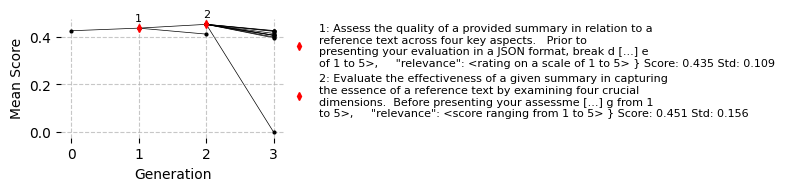

In [34]:
fig, ax = plot_optimization_trajectories(
    prompt_set_se, figsize=(8, 2), n_top_prompt_display=2
)

In [35]:
fig.savefig("f1.png", bbox_inches="tight", dpi=300)